In [ ]:
# Copyright 2025 Andrew Lehr
# The MIT License

# Fig 3b,c. Comparing subspace projections across different projection matrices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import os

In [2]:
from submanifolds.ringnet import Plot
from submanifolds.utils import DataManager

## Parameters

In [3]:
# if new experiment is run, need to fill in name of folder here!
exp_data_dir = 'subspace_exp_2025-04-15_08:53:39'
manage = DataManager(exp_data_dir)

In [4]:
rescale_flag = manage.params_to_iterate['rescale']
shift_percent = manage.params_to_iterate['shift_percent']
perc_selectivity = manage.params_to_iterate['p_inh']
seeds = manage.params_to_iterate['seed']
static_parameters = tuple(val[0] for val in manage.params_to_set.values())

In [5]:
parameter_setting = (True, 0, 0, 0) + static_parameters
net = manage.load_data(parameter_setting)

In [6]:
N = net.params.N
T = net.params.T
n_rescale = len(rescale_flag)
n_perc_sel = len(perc_selectivity)
n_shifts = len(shift_percent)
n_seeds = len(seeds)

shift_val = 0.1
shift_ind = np.where(shift_percent == shift_val)[0][0]

In [7]:
colors = ['dimgrey','#586ba4', '#f68e5f', '#f5dd90', '#324376', '#f76c5e', 
          '#067d7a', '#77c1b3', '#f3c759', '#ed7364', '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

palette = ['#C47475', '#7F9CB0'] # ['#009E92', '#7F9CB0'] #['#1D7874', '#99A88C']

In [8]:
sns.set_style('ticks')  # seaborn style
ticksize = 16           # set tick font size
labelsize = 20          # set plot label sizes

In [9]:
n_components = 3
rescale_val = True

In [11]:
# figure storage
fig_dir = manage.root + 'figures/figure_3/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
    
save_figs_flag = 1

## Compute PCA 

Compute for each percent selectivity, shift percent, and seed

In [13]:
pca_data = {}
exp_var = np.zeros((n_perc_sel, n_shifts, n_seeds, n_components))
exp_var_mean = np.zeros((n_perc_sel, n_shifts, n_components))
exp_var_std = np.zeros((n_perc_sel, n_shifts, n_components))

for k, p in enumerate(perc_selectivity):
    for i, s in enumerate(shift_percent):
        for j, seed in enumerate(seeds):

            # build parameter tuple, point in parameter space
            parameter_setting = (rescale_val, p, seed, s) + static_parameters

            # load network instance belonging to that parameter setting
            net = manage.load_data(parameter_setting)

            # extract activity 
            R = net.R

            # transpose the data for PCA function
            R_transposed = R.T

            # center the data
            R_centered = StandardScaler().fit_transform(R_transposed)

            # compute PCA
            pca_data[k,i,j] = decomposition.PCA(n_components=n_components)
            pca_data[k,i,j].fit_transform(R_centered)
            
            # store explained variance data
            exp_var[k,i,j,:] = pca_data[k,i,j].explained_variance_ratio_.cumsum()
            exp_var_mean[k,i,:] = exp_var[k,i,:,:].mean(axis=0)
            exp_var_std[k,i,:] = exp_var[k,i,:,:].std(axis=0)

            print('\rCurrent setting: ' + str(parameter_setting), end='')

Current setting: (True, 0.95, 9, 0.15, 'transient', 'projection')

## (additional) Cumulative variance

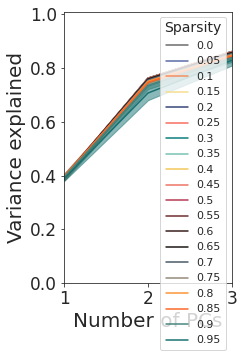

In [14]:
sns.set_style("ticks")

#plt.title(exp.param_space[k*n_subnets])
shift_ex = np.where(shift_percent == 0.1)[0][0]
comps = np.arange(0,3,1)
plt.figure(figsize=(3,5))

for k in range(n_perc_sel):
    plt.plot(comps, exp_var_mean[k,shift_ex,], color=colors[k], label=perc_selectivity[k])
    plt.fill_between(comps, exp_var_mean[k,shift_ex,]-exp_var_std[k,shift_ex,], 
                     exp_var_mean[k,shift_ex,]+exp_var_std[k,shift_ex,], color=colors[k], alpha=0.5)

plt.xlim(0,n_components-1)
plt.ylim(0,1.01)
plt.xlabel('Number of PCs', fontsize=20)
plt.ylabel('Variance explained', fontsize=20)
plt.xticks([0,1,2], [1,2,3], fontsize=17)
plt.yticks(fontsize=17)
leg = plt.legend(fontsize=11)
leg.set_title('Sparsity',prop={'size':14})

#fname = figure_dir + sel + '_explained_variance_by_sparsity.pdf'
#plt.savefig(fname, bbox_inches="tight")

plt.show()

### Principal angles

In [15]:
angles = np.zeros((n_perc_sel, n_shifts, int(n_seeds*(n_seeds-1)/2), n_components))
angles_mean = np.zeros((n_perc_sel, n_shifts, n_components))
angles_std = np.zeros((n_perc_sel, n_shifts, n_components))

for k, p in enumerate(perc_selectivity):
    for i, s in enumerate(shift_percent):
        count = 0
        for j in range(n_seeds):
            for l in range(j+1, n_seeds):
                u, s, vh = np.linalg.svd(np.dot(pca_data[k,i,j].components_, pca_data[k,i,l].components_.T), full_matrices=True)
                angles[k, i, count, :] = np.arccos(np.clip(s, -1, 1))*180/np.pi
                count += 1
    
angles_mean = angles.mean(axis=2)
angles_std = angles.std(axis=2)

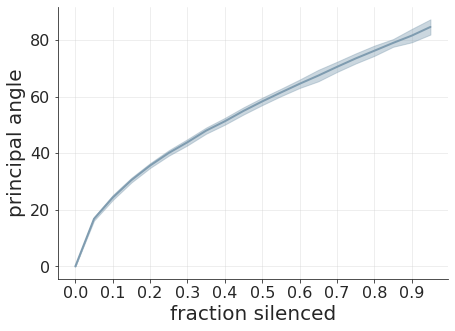

In [16]:
fname = 'principal_angle.pdf'

ind = 0

fig, ax = plt.subplots(figsize=(7,5))
plt.plot(perc_selectivity, angles_mean[:,shift_ind,ind], color=palette[1], linewidth=2)
plt.fill_between(perc_selectivity, 
                 angles_mean[:,shift_ind,ind]-angles_std[:,shift_ind,ind], 
                 angles_mean[:,shift_ind,ind]+angles_std[:,shift_ind,ind], color=palette[1], alpha=0.4)


# formatting plot
plt.xlabel('fraction silenced', fontsize=20)
plt.ylabel('principal angle', fontsize=20)
plt.xticks(np.arange(0,1,0.1), fontsize=17)
plt.yticks(fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=ticksize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(alpha=0.4)
#plt.legend(fontsize=labelsize, frameon=False)

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

## Projections and projection magnitude

## Fig. 3b. 2D projection

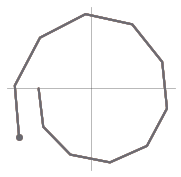

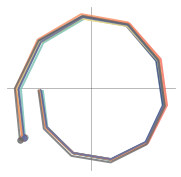

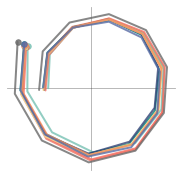

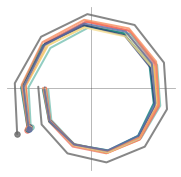

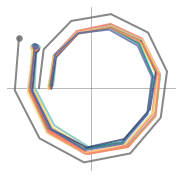

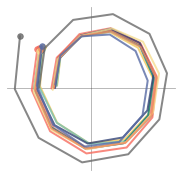

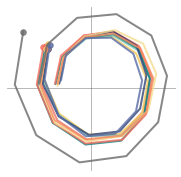

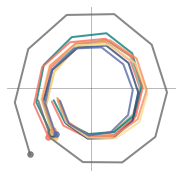

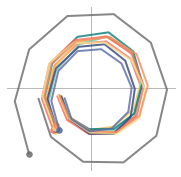

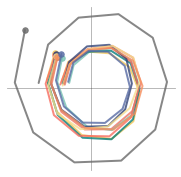

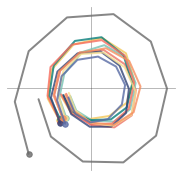

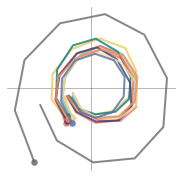

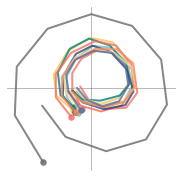

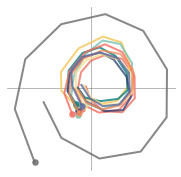

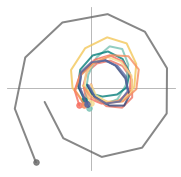

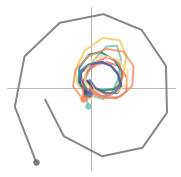

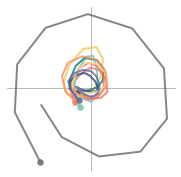

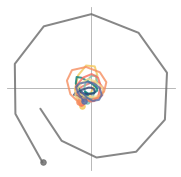

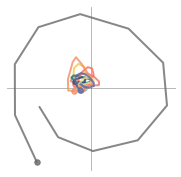

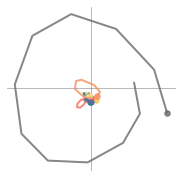

In [17]:
pc0 = 0
pc1 = 1

t_start = 0
t_stop = 12

seed_ind = 0

proj_magnitude_in_space = defaultdict(list)
proj_magnitude_out_space = defaultdict(list)

for k, p in enumerate(perc_selectivity):

    fig, ax = plt.subplots(figsize=(3,3))
    for j, seed in enumerate(seeds):
        # build parameter tuple, point in parameter space
        parameter_setting = (rescale_val, p, seed, shift_val) + static_parameters

        # load network instance belonging to that parameter setting
        net = manage.load_data(parameter_setting)

        # extract activity 
        R = net.R

        # project
        proj = np.dot(pca_data[k,shift_ind,seed_ind].components_, R)
        c0 = proj[pc0,t_start:t_stop], proj[pc1,t_start:t_stop]

        ax.plot(*c0, colors[j%len(colors)], linewidth=2, zorder=(20-j), alpha=0.8) #, alpha=(i+1)/nTrials)
        ax.scatter(c0[0][0], c0[1][0], c=colors[j%len(colors)], s=30, zorder=(20-j), alpha=0.8)
    
    #ax.set_xlabel('PC'+str(pc0+1), loc='right', fontsize=12, alpha=0.8)
    #ax.set_ylabel('PC'+str(pc1+1), loc='top', fontsize=12, alpha=0.8)

    plt.xticks([], fontsize=17)
    plt.yticks([], fontsize=17)
    
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.spines['bottom'].set(alpha=0.4)
    ax.spines['left'].set(alpha=0.4)
    
    ax.spines['bottom'].set_position('center')
    ax.spines['left'].set_position('center')
    
    fname = 'projection_perc_sel_' + str(p) + '.pdf'
    if save_figs_flag:
        plt.savefig(fig_dir+fname, bbox_inches="tight")
    
    plt.show()

In [18]:
pc0 = 0
pc1 = 1

t_start = 0
t_stop = 12

proj_magnitude_in_space = np.zeros((n_perc_sel, n_shifts, n_seeds))
proj_magnitude_out_space = np.zeros((n_perc_sel, n_shifts, int(n_seeds*(n_seeds-1)/2)))

for k, p in enumerate(perc_selectivity):
    for i, s in enumerate(shift_percent):
        count = 0
        for j, seed_j in enumerate(seeds):
            
            # build parameter tuple, point in parameter space
            parameter_setting = (rescale_val, p, seed_j, s) + static_parameters

            # load network instance belonging to that parameter setting
            net = manage.load_data(parameter_setting)

            # extract activity 
            R_j = net.R
            
            # project activity from l into space j
            proj = np.dot(pca_data[k,i,j].components_, R_j)

            # compute projection magnitude
            x_max = proj[pc0,:].max() - proj[pc0,:].min()
            y_max = proj[pc1,:].max() - proj[pc1,:].min()
            avg_magnitude = np.mean([x_max,y_max])
            
            proj_magnitude_in_space[k,i,j] = avg_magnitude
            
            for l, seed_l in enumerate(seeds[j+1:]):
            
                # build parameter tuple, point in parameter space
                parameter_setting = (rescale_val, p, seed_l, s) + static_parameters

                # load network instance belonging to that parameter setting
                net = manage.load_data(parameter_setting)

                # extract activity 
                R_l = net.R

                # project activity from l into space j
                proj = np.dot(pca_data[k,i,j].components_, R_l)

                # compute projection magnitude
                x_max = proj[pc0,:].max() - proj[pc0,:].min()
                y_max = proj[pc1,:].max() - proj[pc1,:].min()
                avg_magnitude = np.mean([x_max,y_max])
                
                if seed_j == seed_l:
                    print('error')
                else:
                    proj_magnitude_out_space[k,i,count] = avg_magnitude/proj_magnitude_in_space[k,i,j]
                count += 1


In [19]:
proj_magnitude_out_space_mean = proj_magnitude_out_space.mean(axis=2)
proj_magnitude_out_space_std = proj_magnitude_out_space.std(axis=2)

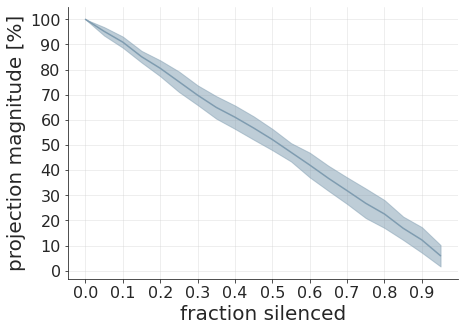

In [20]:
fname = 'projection_magnitude.pdf'

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(perc_selectivity, proj_magnitude_out_space_mean[:,shift_ind], color=palette[1])
ax.fill_between(perc_selectivity, 
                proj_magnitude_out_space_mean[:,shift_ind]-proj_magnitude_out_space_std[:,shift_ind],
                proj_magnitude_out_space_mean[:,shift_ind]+proj_magnitude_out_space_std[:,shift_ind],
                color=palette[1],
                alpha=0.5)

plt.xlabel('fraction silenced', fontsize=20)
plt.ylabel('projection magnitude [%]', fontsize=20)
plt.xticks(np.arange(0,1,0.1), fontsize=17)
plt.yticks(np.arange(0,1.1,.1), np.arange(0,110,10), fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=ticksize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(alpha=0.4)
#plt.legend(fontsize=labelsize, frameon=False)

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

### Fig. 2c. Double y-axis

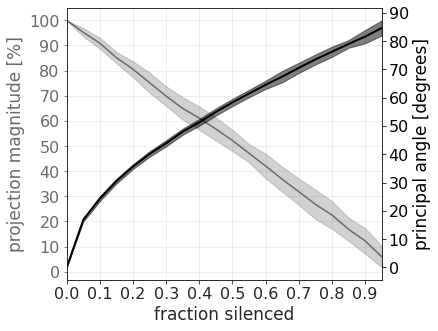

In [24]:
fname = 'double_axis_principal_angle_and_projection_magnitude.pdf'

fig, ax = plt.subplots(figsize=(7,5))
fig.subplots_adjust(right=0.75)

twin = ax.twinx()

p2, = twin.plot(perc_selectivity, angles_mean[:,shift_ind,0], color='black', linewidth=2)
twin.fill_between(perc_selectivity, 
                 angles_mean[:,shift_ind,0]-angles_std[:,shift_ind,0], 
                 angles_mean[:,shift_ind,0]+angles_std[:,shift_ind,0], color='black', alpha=0.5)

p1, = ax.plot(perc_selectivity, proj_magnitude_out_space_mean[:,shift_ind], color='dimgrey')
ax.fill_between(perc_selectivity, 
                proj_magnitude_out_space_mean[:,shift_ind]-proj_magnitude_out_space_std[:,shift_ind],
                proj_magnitude_out_space_mean[:,shift_ind]+proj_magnitude_out_space_std[:,shift_ind],
                color='dimgrey',
                alpha=0.3)

ax.set_xlabel("fraction silenced", fontsize=17)
twin.set_ylabel("principal angle [degrees]", fontsize=17)
ax.set_ylabel("projection magnitude [%]", fontsize=17)

twin.set_xlim(0,.95)
twin.set_xticks(np.arange(0,1,.1))
ax.set_yticks(np.arange(0,1.1,.1), np.arange(0,110,10))
twin.set_yticks(np.arange(0,100,10))

twin.yaxis.label.set_color(p2.get_color())
ax.yaxis.label.set_color(p1.get_color())

twin.tick_params(axis='y', colors=p2.get_color())
ax.tick_params(axis='y', colors=p1.get_color())

#ax.legend(handles=[p1, p2])

twin.tick_params(axis='both', which='major', labelsize=ticksize)
ax.tick_params(axis='both', which='major', labelsize=ticksize)

ax.grid(alpha=0.4)

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

plt.show()